Music Taste Analysis using cross validation and model tuning on biased dataset

In [4]:
pip install spotipy

  Created wheel for spotipy: filename=spotipy-2.4.4-cp36-none-any.whl size=12336 sha256=5dc3e78133b35d49e1f6fc47d20c8b655bf69285fd3f9449f55a0a3450bc481e
  Stored in directory: /root/.cache/pip/wheels/76/28/19/a86ca9bb0e32dbd4a4f580870250f5aeef852870578e0427e6
Successfully built spotipy


In [0]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn import ensemble

sns.set()
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials  # To access authorised Spotify data


In [0]:
client_id = "7df335489096457ca820d54e203ecec8"
client_secret = "b7919f370c884a37a192912b019c08bd"

client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)  # spotify object to access API


In [0]:
def prepare_data(artist):
    name = artist  # chosen artist
    result = sp.search(name)  # search query
    print(result['tracks']['items'][0]['artists'])

    # Extract Artist's uri
    artist_uri = result['tracks']['items'][0]['artists'][0]['uri']
    # Pull all of the artist's albums
    sp_albums = sp.artist_albums(artist_uri, album_type='album')
    # Store artist's albums' names' and uris in separate lists
    album_names = []
    album_uris = []
    for i in range(len(sp_albums['items'])):
        album_names.append(sp_albums['items'][i]['name'])
        album_uris.append(sp_albums['items'][i]['uri'])

    print(album_names)
    print(album_uris)

    # Keep names and uris in same order to keep track of duplicate albums

    spotify_albums = {}

    def albumSongs(uri, album_count):
        album = uri  # assign album uri to a_name
        spotify_albums[album] = {}  # Creates dictionary for that specific album
        # Create keys-values of empty lists inside nested dictionary for album
        spotify_albums[album]['album'] = []  # create empty list
        spotify_albums[album]['track_number'] = []
        spotify_albums[album]['id'] = []
        spotify_albums[album]['name'] = []
        spotify_albums[album]['uri'] = []

        tracks = sp.album_tracks(album)  # pull data on album tracks
        for n in range(len(tracks['items'])):  # for each song track
            spotify_albums[album]['album'].append(album_names[album_count])  # append album name tracked via album_count
            spotify_albums[album]['track_number'].append(tracks['items'][n]['track_number'])
            spotify_albums[album]['id'].append(tracks['items'][n]['id'])
            spotify_albums[album]['name'].append(tracks['items'][n]['name'])
            spotify_albums[album]['uri'].append(tracks['items'][n]['uri'])

    album_count = 0
    for i in album_uris:  # each album
        albumSongs(i, album_count)
        print("Album " + str(album_names[album_count]) + " songs has been added to spotify_albums dictionary")
        album_count += 1  # Updates album count once all tracks have been added

    def audio_features(album):
        # Add new key-values to store audio features
        spotify_albums[album]['acousticness'] = []
        spotify_albums[album]['danceability'] = []
        spotify_albums[album]['energy'] = []
        spotify_albums[album]['instrumentalness'] = []
        spotify_albums[album]['liveness'] = []
        spotify_albums[album]['loudness'] = []
        spotify_albums[album]['speechiness'] = []
        spotify_albums[album]['tempo'] = []
        spotify_albums[album]['valence'] = []
        spotify_albums[album]['popularity'] = []
        # create a track counter
        track_count = 0
        for track in spotify_albums[album]['uri']:
            # pull audio features per track
            features = sp.audio_features(track)

            # Append to relevant key-value
            spotify_albums[album]['acousticness'].append(features[0]['acousticness'])
            spotify_albums[album]['danceability'].append(features[0]['danceability'])
            spotify_albums[album]['energy'].append(features[0]['energy'])
            spotify_albums[album]['instrumentalness'].append(features[0]['instrumentalness'])
            spotify_albums[album]['liveness'].append(features[0]['liveness'])
            spotify_albums[album]['loudness'].append(features[0]['loudness'])
            spotify_albums[album]['speechiness'].append(features[0]['speechiness'])
            spotify_albums[album]['tempo'].append(features[0]['tempo'])
            spotify_albums[album]['valence'].append(features[0]['valence'])
            # popularity is stored
            pop = sp.track(track)
            spotify_albums[album]['popularity'].append(pop['popularity'])
            track_count += 1

    
    sleep_min = 2
    sleep_max = 5
    start_time = time.time()
    request_count = 0
    for i in spotify_albums:
        audio_features(i)
        request_count += 1
        if request_count % 5 == 0:
            print(str(request_count) + " playlists completed")
            time.sleep(np.random.uniform(sleep_min, sleep_max))
            print('Loop #: {}'.format(request_count))
            print('Elapsed Time: {} seconds'.format(time.time() - start_time))
    

    dic_df = {}
    dic_df['album'] = []
    dic_df['track_number'] = []
    dic_df['id'] = []
    dic_df['name'] = []
    dic_df['uri'] = []
    dic_df['acousticness'] = []
    dic_df['danceability'] = []
    dic_df['energy'] = []
    dic_df['instrumentalness'] = []
    dic_df['liveness'] = []
    dic_df['loudness'] = []
    dic_df['speechiness'] = []
    dic_df['tempo'] = []
    dic_df['valence'] = []
    dic_df['popularity'] = []
    for album in spotify_albums:
        for feature in spotify_albums[album]:
            dic_df[feature].extend(spotify_albums[album][feature])

    len(dic_df['album'])

    df = pd.DataFrame.from_dict(dic_df)
    return df

    # final_df = df.sort_values('popularity', ascending=False).drop_duplicates('name').sort_index()
    # final_df['user'] = [1] * len(final_df.index)

    # final_df.to_csv("dataset/spotify_data_"+ artist + ".csv")

In [0]:
def add_label_column(df, value, artist):
  final_df = df.sort_values('popularity', ascending=False).drop_duplicates('name').sort_index()
  final_df['user'] = [value] * len(final_df.index)

  final_df.to_csv("dataset/spotify_data_"+ artist + ".csv")
  return final_df

In [0]:
def combine_multiple_files():
    # combine all music files from different users
    user2_combined_songs_csv = pd.concat(
        ([pd.read_csv(f) for f in ['dataset/spotify_data_Anirudh.csv', 'dataset/spotify_data_Ravi Basrur.csv']]),
        sort=False)
    user2_combined_songs_csv.to_csv('dataset/user_2_songs.csv', index=False)

    user2_csv = pd.read_csv('dataset/user_2_songs.csv')
    
    #uncomment this if created file for shakira
    #    combined_csv = pd.concat(([pd.read_csv(f) for f in ['dataset/spotify_data_Shakira.csv','dataset/user_2_songs.csv', 'dataset/spotify_data_Owl City.csv', 'dataset/spotify_data_Akon.csv']]), sort=False)

    combined_csv = pd.concat(([pd.read_csv(f) for f in ['dataset/spotify_data_Akon.csv','dataset/user_2_songs.csv', 'dataset/spotify_data_Owl City.csv']]),
                             sort=False)
    combined_csv.to_csv('dataset/combined_csv.csv', index=False)

In [0]:
#Artists liked by User1
df1 = prepare_data('Ravi Basrur')
final_df = add_label_column(df1, 0, 'Ravi Basrur')
df2 = prepare_data('Anirudh')
final_df = add_label_column(df2, 0, 'Anirudh')


#Artists liked by User0
df3 = prepare_data('Akon')
final_df = add_label_column(df3, 1, 'Akon')
df4 = prepare_data('Owl City')
final_df = add_label_column(df4, 1, 'Owl City')

#Uncomment this to get 50-50 split for complete dataset
#df5 = prepare_data('Shakira')
#final_df = add_label_column(df5, 1, 'Shakira')



[{'external_urls': {'spotify': 'https://open.spotify.com/artist/4iA6bUhiZyvRKJf4FNVX39'}, 'href': 'https://api.spotify.com/v1/artists/4iA6bUhiZyvRKJf4FNVX39', 'id': '4iA6bUhiZyvRKJf4FNVX39', 'name': 'Vijay Prakash', 'type': 'artist', 'uri': 'spotify:artist:4iA6bUhiZyvRKJf4FNVX39'}, {'external_urls': {'spotify': 'https://open.spotify.com/artist/7B8fJFL2TEAi4GlHHCHba2'}, 'href': 'https://api.spotify.com/v1/artists/7B8fJFL2TEAi4GlHHCHba2', 'id': '7B8fJFL2TEAi4GlHHCHba2', 'name': 'Shri Krishna', 'type': 'artist', 'uri': 'spotify:artist:7B8fJFL2TEAi4GlHHCHba2'}, {'external_urls': {'spotify': 'https://open.spotify.com/artist/4JLzPvsQcq1YxZkEvgax48'}, 'href': 'https://api.spotify.com/v1/artists/4JLzPvsQcq1YxZkEvgax48', 'id': '4JLzPvsQcq1YxZkEvgax48', 'name': 'Lokeshwar', 'type': 'artist', 'uri': 'spotify:artist:4JLzPvsQcq1YxZkEvgax48'}, {'external_urls': {'spotify': 'https://open.spotify.com/artist/1ZKWEgONUTL99f0niqmUA4'}, 'href': 'https://api.spotify.com/v1/artists/1ZKWEgONUTL99f0niqmUA4', 

In [0]:
#combine all files into one csv file

combine_multiple_files()

In [7]:
spotify_albums = pd.read_csv('dataset/combined_csv.csv', delimiter=',', )
print("Size of dataset = ", spotify_albums.shape)

Size of dataset =  (654, 17)


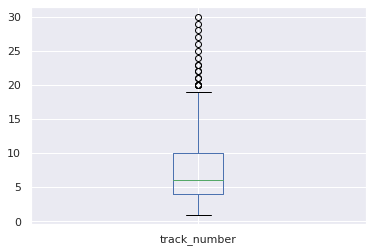

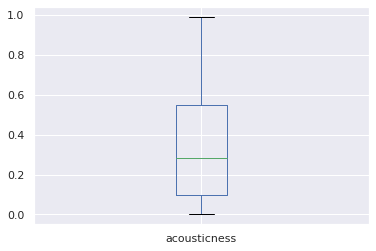

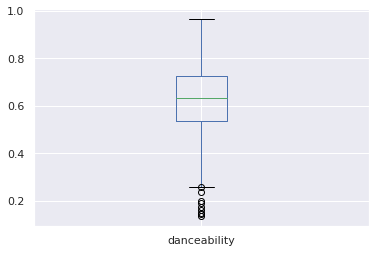

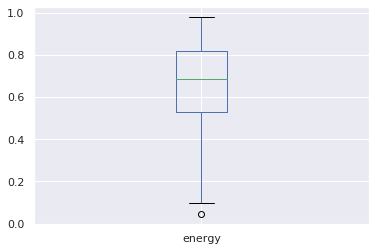

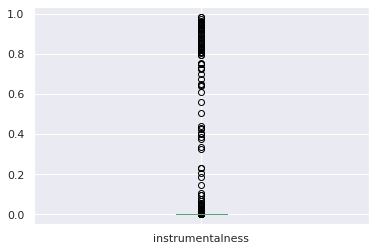

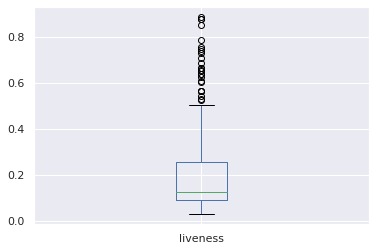

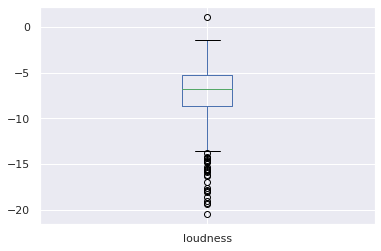

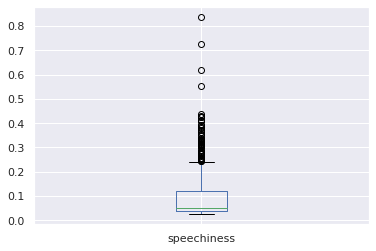

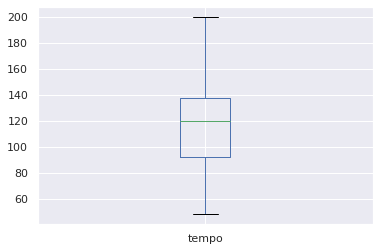

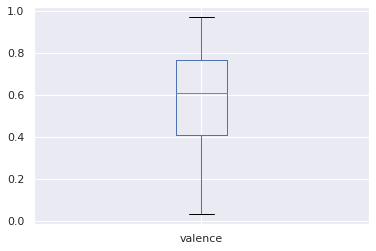

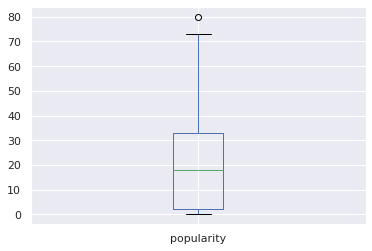

In [0]:
def show_box_plot_for_columns():
    spotify_albums.boxplot('track_number')
    plt.show()

    spotify_albums.boxplot('acousticness')
    plt.show()

    spotify_albums.boxplot('danceability')
    plt.show()

    spotify_albums.boxplot('energy')
    plt.show()

    spotify_albums.boxplot('instrumentalness')
    plt.show()

    spotify_albums.boxplot('liveness')
    plt.show()

    spotify_albums.boxplot('loudness')
    plt.show()

    spotify_albums.boxplot('speechiness')
    plt.show()

    spotify_albums.boxplot('tempo')
    plt.show()

    spotify_albums.boxplot('valence')
    plt.show()

    spotify_albums.boxplot('popularity')
    plt.show()


show_box_plot_for_columns()



corr['energy']['acousticness'] -0.49836628213815626
corr['loudness']['acousticness'] -0.404015545506711
corr['energy']['loudness'] 0.7319243944462913


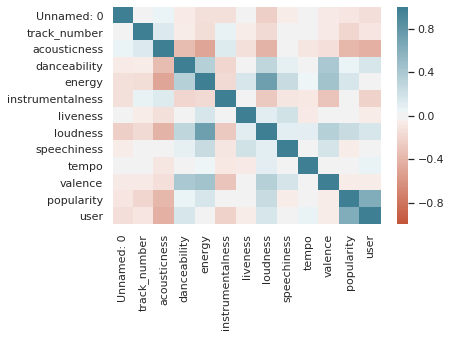

In [0]:
def show_corr_matrix():
    corr = spotify_albums.corr()
    print("corr['energy']['acousticness']", corr['energy']['acousticness'])
    print("corr['loudness']['acousticness']", corr['loudness']['acousticness'])
    print("corr['energy']['loudness']", corr['loudness']['energy'])
    ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200))
    plt.show()


show_corr_matrix()


In [0]:
########################### Model building #################################
#K-fold cross validation 
k_fold = KFold(n_splits=3, random_state=42, shuffle=True)

spotify_albums.drop(["Unnamed: 0", "album", "id", "name", "uri", "track_number"], axis=1, inplace=True)

features_cols = [col for col in spotify_albums.columns if col not in ['user']]
features = spotify_albums[features_cols]

print("Columns", features_cols)

features = pd.DataFrame(preprocessing.normalize(features, axis=0, return_norm=False), columns=features.columns, index=features.index)

label = spotify_albums['user']
print("features", features)
print("labels", label)

x_train = []
x_test = []
y_train=[]
y_test = []
for train_index, test_index in k_fold.split(features):
    x_train, x_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = label.iloc[train_index], label.iloc[test_index]


################## Logistic Regression ##########################
model = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000, class_weight = 'balanced')
model.fit(x_train, y_train)
print(model)

predict = model.predict(x_test)
print("x_test", x_test)
print(predict)

conf_matrix = metrics.confusion_matrix(y_test, predict)
print(conf_matrix)


print("Accuracy score using Logistic Regression :", metrics.accuracy_score(y_test,predict))

precision = metrics.precision_score(y_test,predict)
print("Precision using Logistic Regression = ", precision)

recall = metrics.recall_score(y_test, predict)
print("Recall using Logistic Regression = ", recall)

print("F1 score using Logistic Regression: ", metrics.f1_score(y_test,predict))
print("Area under ROC curve for Logistic Regression ",metrics.roc_auc_score(y_test, predict))


Columns ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'popularity']
features      acousticness  danceability    energy  ...     tempo   valence  popularity
0        0.010684      0.049539  0.043109  ...  0.037115  0.046446    0.062636
1        0.009801      0.057448  0.045035  ...  0.040614  0.053224    0.061145
2        0.002199      0.046474  0.051833  ...  0.038383  0.060317    0.073076
3        0.008000      0.057019  0.046735  ...  0.039015  0.034960    0.061145
4        0.016953      0.052666  0.053589  ...  0.038372  0.053789    0.056671
..            ...           ...       ...  ...       ...       ...         ...
649      0.003488      0.031943  0.048151  ...  0.025588  0.043998    0.044740
650      0.021544      0.037829  0.034669  ...  0.023988  0.061070    0.040266
651      0.028431      0.040833  0.029287  ...  0.038379  0.038286    0.038775
652      0.016247      0.040894  0.028324  ...  0.038374 

In [0]:
####################### Decision Tree ##############################

model = tree.DecisionTreeClassifier(random_state =50, class_weight='balanced', max_leaf_nodes=500)
print("Decision tree model: ", model)
model.fit(x_train, y_train)
y_predict = model.predict(x_test)

conf_matrix = metrics.confusion_matrix(y_test, y_predict)
print("conf_matrix using Decision tree = ", conf_matrix)

accuracy = metrics.accuracy_score(y_test, y_predict)
print("Accuracy using Decision Tree = ", accuracy)

precision = metrics.precision_score(y_test, y_predict)
print("Precision using Decision Tree = ", precision)

recall = metrics.recall_score(y_test, y_predict)
print("Recall using Decision Tree = ", recall)

f1_score = metrics.f1_score(y_test,y_predict)
print("F1 score using Decision tree:", f1_score)
print("Area under ROC curve for Decision tree ",metrics.roc_auc_score(y_test, y_predict))



Decision tree model:  DecisionTreeClassifier(class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=500,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=50, splitter='best')
conf_matrix using Decision tree =  [[134  17]
 [ 17  50]]
Accuracy using Decision Tree =  0.8440366972477065
Precision using Decision Tree =  0.746268656716418
Recall using Decision Tree =  0.746268656716418
F1 score using Decision tree: 0.746268656716418
Area under ROC curve for Decision tree  0.8168429376297321


In [0]:
####################### Random Forest ##############################

model = ensemble.RandomForestClassifier(n_estimators=300, criterion='gini', oob_score=True, random_state=0, max_leaf_nodes=500, class_weight='balanced')
print("Random forest model: ", model)
model.fit(x_train, y_train)
y_predict = model.predict(x_test)

conf_matrix = metrics.confusion_matrix(y_test, y_predict)
print("conf_matrix using Random forest = ", conf_matrix)

accuracy = metrics.accuracy_score(y_test, y_predict)
print("Accuracy using Random forest = ", accuracy)

precision = metrics.precision_score(y_test, y_predict)
print("Precision using Random forest = ", precision)

recall = metrics.recall_score(y_test, y_predict)
print("Recall using Random forest = ", recall)

f1_score = metrics.f1_score(y_test,y_predict)
print("F1 score using Random forest:", f1_score)

print("Area under ROC curve for Random Forest ", metrics.roc_auc_score(y_test, y_predict))


Random forest model:  RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=500, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=300, n_jobs=None, oob_score=True,
                       random_state=0, verbose=0, warm_start=False)
conf_matrix using Random forest =  [[144   7]
 [  8  59]]
Accuracy using Random forest =  0.9311926605504587
Precision using Random forest =  0.8939393939393939
Recall using Random forest =  0.8805970149253731
F1 score using Random forest: 0.887218045112782
Area under ROC curve for Random Forest  0.9171196995156667
